# Train Astro R-CNN

Simple example notebook of how to train Mask R-CNN on PhoSim data

In [1]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# train
import astro_rcnn
from astro_rcnn import PhoSimDataset
from astro_rcnn import DESConfig

# mrcnn
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
TRAIN_DIR = os.path.abspath("./trainingset/")
VAL_DIR = os.path.abspath("./validationset/")


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
#model path
model_path = os.path.join(MODEL_DIR, "astro_rcnn_des.h5")


%matplotlib inline


Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Dataset

Load dataset of DES image

In [3]:
## Config

class TrainConfig(DESConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

train_config = TrainConfig()
train_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Create Model

In [4]:
## DATASET

# Training dataset
dataset_train = PhoSimDataset()
dataset_train.load_sources(TRAIN_DIR)
dataset_train.prepare()

# Validation dataset
dataset_val = PhoSimDataset()
dataset_val.load_sources(VAL_DIR)
dataset_val.prepare()

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


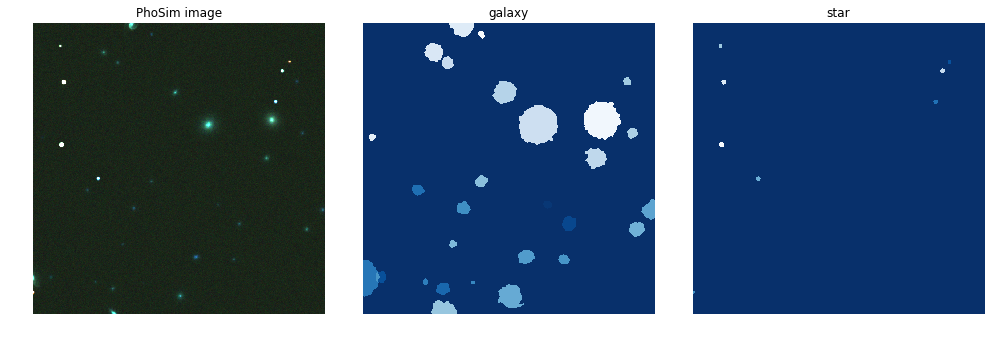

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


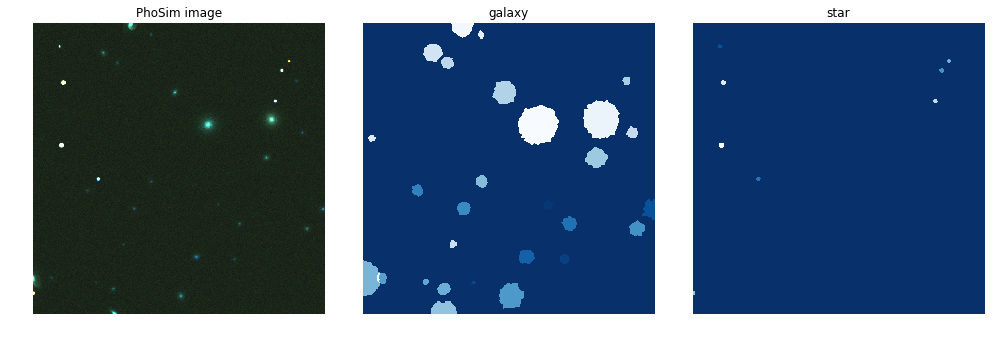

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


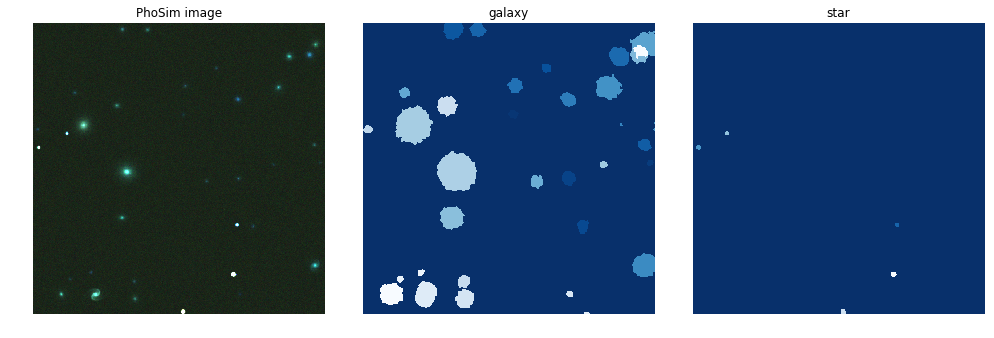

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    image_show = image.copy()
    image_show[:,:,2] = 0.6*image_show[:,:,2] # colors
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image_show, mask, class_ids, dataset_train.class_names)

## CREATE MODEL

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=train_config, model_dir=MODEL_DIR)

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])


In [6]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=train_config.LEARNING_RATE,
            epochs=1,
            layers='heads')

# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=train_config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")

# Save weights
model.keras_model.save_weights(model_path)

NameError: name 'config' is not defined

## Detection

In [5]:
class InferenceConfig(DESConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

original_image           shape: (512, 512, 3)         min:    9.00000  max: 65535.00000  uint32
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (39,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (39, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 39)        min:    0.00000  max:    1.00000  bool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


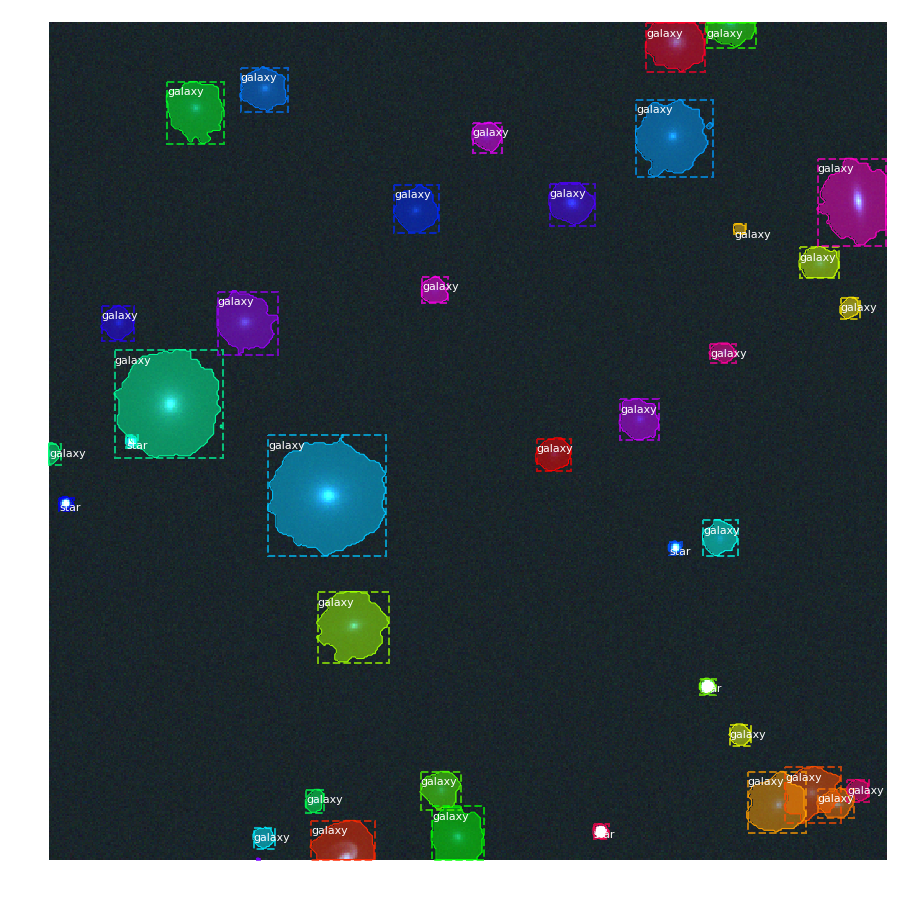

In [6]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image_show = original_image.copy()
image_show[:,:,2] = 0.6*image_show[:,:,2] # colors
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names)

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max: 65535.00000  uint32
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max: 65431.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


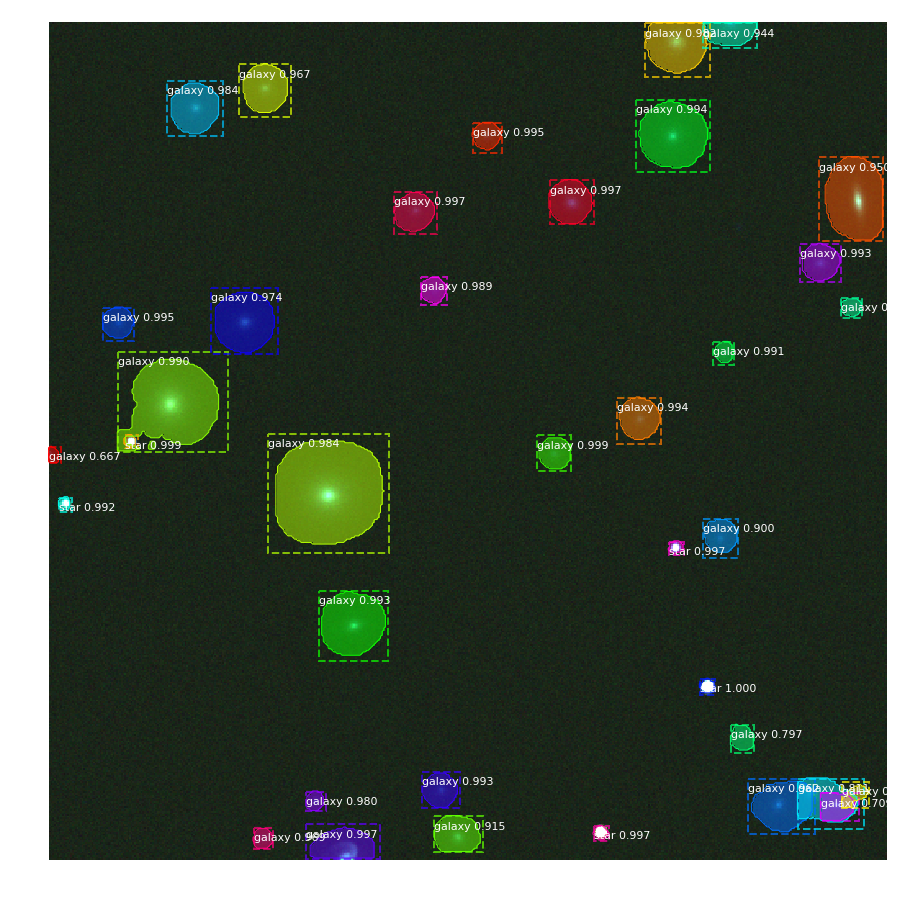

In [7]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(image_show, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

image ID: des.5 (5) 
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max: 65535.00000  uint32
molded_images            shape: (1, 512, 512, 3)      min:    9.00000  max: 65535.00000  uint32
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (39,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (39, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 39)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.870
AP @0.55:	 0.870
AP @0.60:	 0.784
AP @0.65:	 0.784
AP @0.70:	 0.402
AP @0.75:	 0.298
AP @0.80:	 0.095
AP @0.85:	 0.024
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


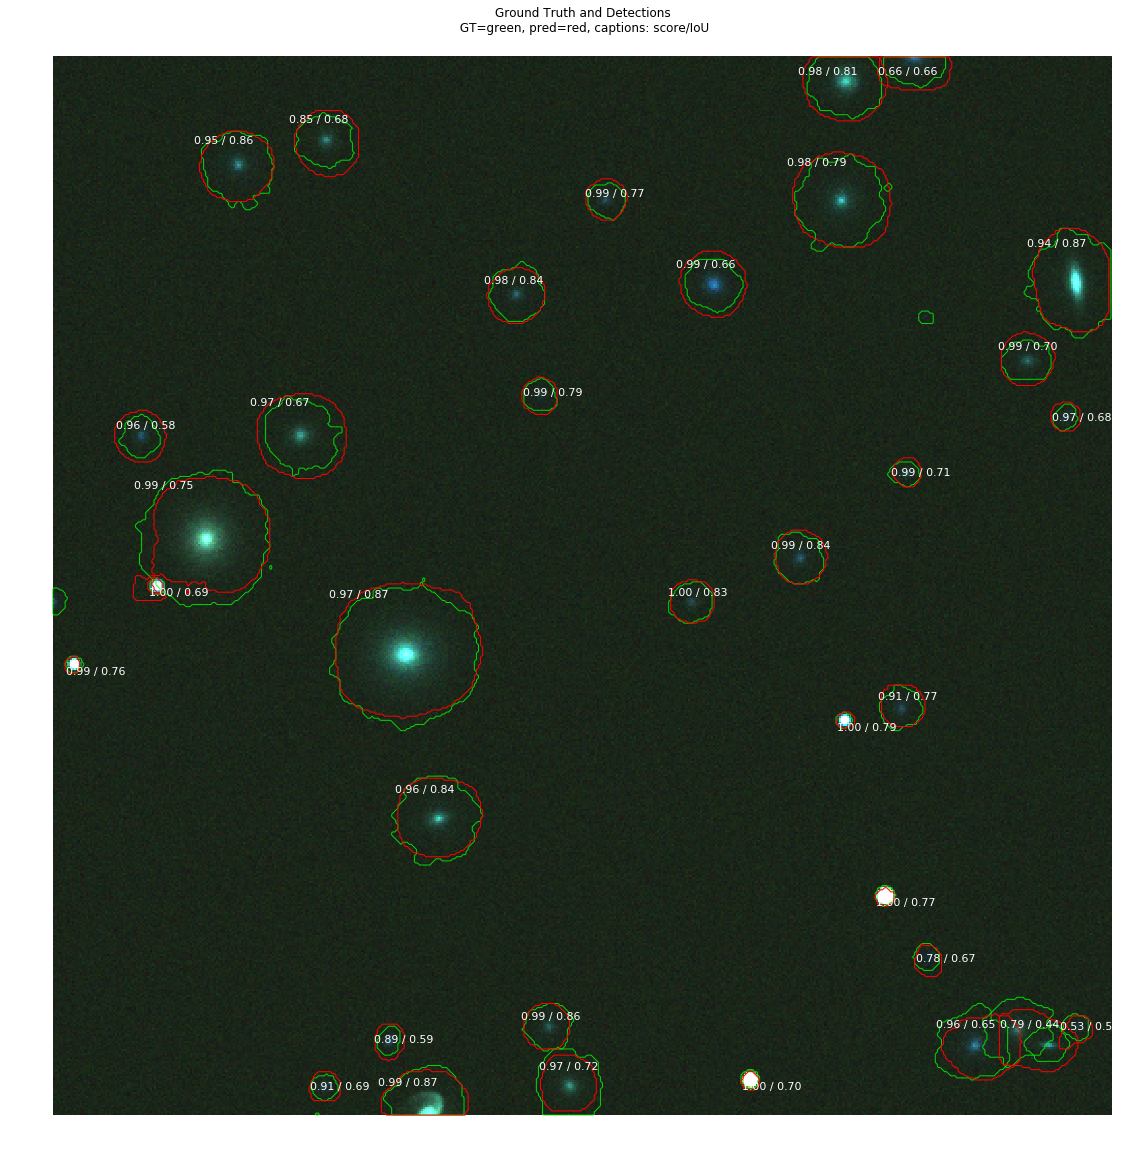

In [8]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image_show,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_val.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

### Compute AP on Batch of Images


In [9]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset_val, dataset_val.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [512 512   3]   AP: 0.37
  1 [512 512   3]   AP: 0.40
  2 [512 512   3]   AP: 0.45
  3 [512 512   3]   AP: 0.42
  4 [512 512   3]   AP: 0.41
Mean AP overa 5 images: 0.4090


## Evaluation

Mean AP score versus IOU thresholds for training set.

In [10]:
# Compute VOC-Style mAP
# May take a few minutes depending on size of validation set
def compute_performance(iou_threshold=0.5):
    APs = []
    ps = []
    rs = []
    for image_id in dataset_val.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=iou_threshold)

        APs.append(AP)
        # interpolate precisions and recalls to achieve same sampling for averaging
        precisions = np.interp(np.linspace(0, len(precisions), 50), np.arange(0, len(precisions)), precisions)
        recalls = np.interp(np.linspace(0, len(recalls), 50), np.arange(0, len(recalls)), recalls)
        ps.append(precisions)
        rs.append(recalls)
    print("mAP: ", np.mean(APs))
    return np.mean(APs), np.mean(ps,0), np.mean(rs,0)

mAP:  0.8860200830631865
mAP:  0.8454680938359003
mAP:  0.7106161912378752
mAP:  0.3511871308844858
mAP:  0.006066564396400743


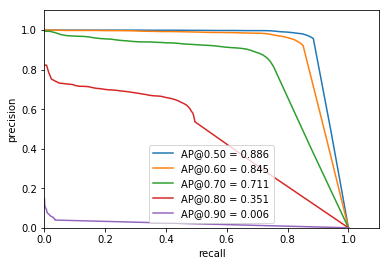

In [12]:
# Plot precision-recall curve over range of IOU thresholds
# This will take a while!
mean_APs = []
mean_ps = []
mean_rs = []
iou_thresholds = np.arange(0.5, 1.0, 0.1)
for i in iou_thresholds:
    APs,ps,rs = compute_performance(i)
    mean_APs.append(APs)
    mean_ps.append(ps)
    mean_rs.append(rs)
    
visualize.plot_precision_recall_range(mean_APs,iou_thresholds,mean_ps,mean_rs)

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

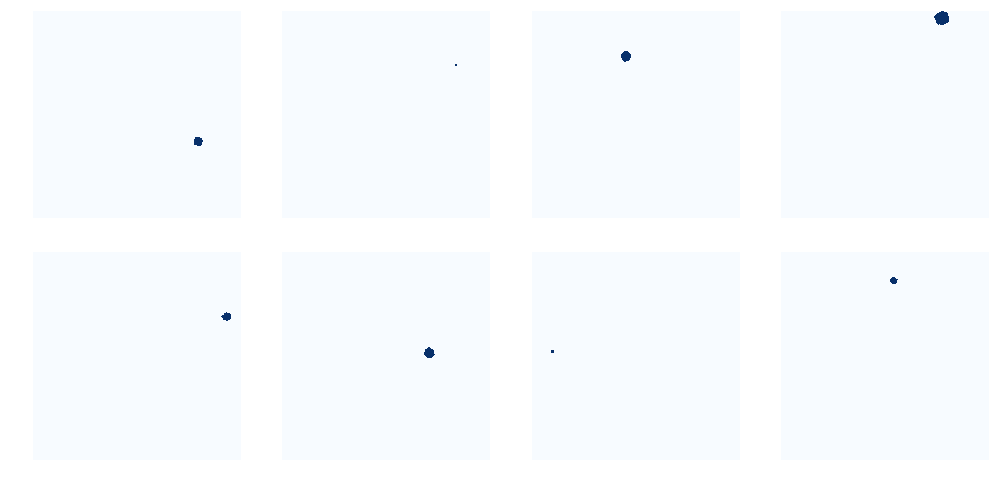

In [43]:
limit = 8
visualize.display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [44]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
34 detections: ['star' 'star' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'star' 'galaxy' 'star'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'star' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy']


In [45]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (34, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (34, 512, 512)        min:    0.00000  max:    1.00000  bool


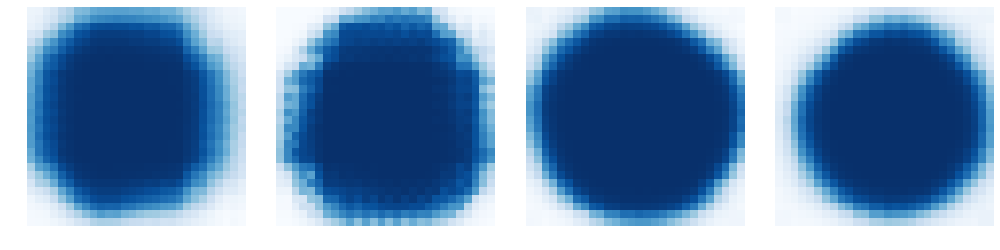

In [46]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

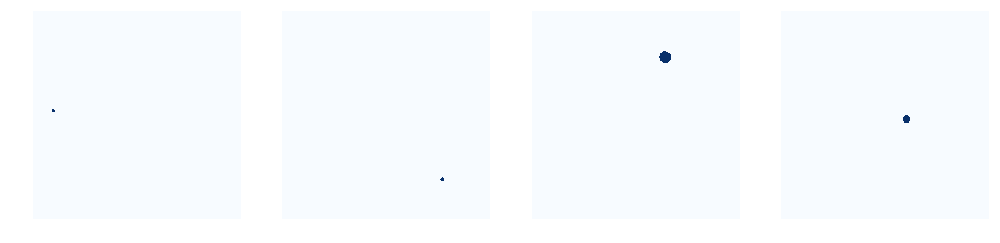

In [47]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [15]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -114.70000  max: 65431.10156  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max: 5179.23242  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max: 4460.86768  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -37.22359  max:  161.21269  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


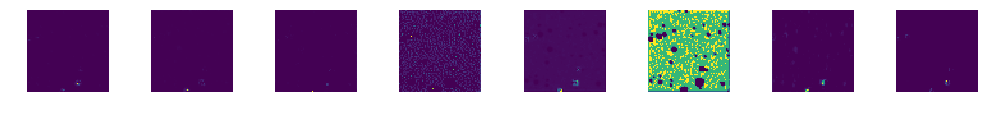

In [17]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res3c_out"][0,:,:,0:8], [2, 0, 1]), cols=8)